In [2]:
#Imports
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
#from tqdm import tqdm

In [4]:
#Data loading 

usefull_columns = ['genres','keywords','popularity']
#TO BE REMOVED to let the user give the array as a parameter of the function. 
Movies = pd.read_csv("../../Datasets/Transformed.csv",usecols=usefull_columns)

#We reduce the dataframe size with only the usefull column to earn some computation time.

In [5]:
#Constant definition

#Cost added if the first genre is similar between two films
first_genre = 5
#Cost added if the secondary genre is similar between two films
second_genre = 1
#Cost added by similar keyword identical between two films
keyword_cost = 1

In [29]:
def cost_function():
    """Define the cost between the film given in index and the others one."""
    costs = np.zeros([Movies.shape[0],Movies.shape[0]])
    
    for i in tqdm(range(Movies.shape[0])):
        current_film = Movies.iloc[i]
        genres_current = get_genres(current_film)
        kw_current = get_keywords(current_film)
        popularity_current = current_film['popularity']

        for j in range(i,Movies.shape[0]):
            cost = 0

            b_film = Movies.iloc[j]
            genres_b = get_genres(b_film)
            popularity_b = b_film['popularity']
            #First we only select the first genre to determine the similarity because it's more important that the other genre.
            if len(genres_current) > 0  & len(genres_b) > 0:
                if (genres_current[0] == genres_b[0]):
                    cost += first_genre

                #This give us the number of similar genres. We pop the first one because we already compare them.
                cost += np.sum(np.in1d(genres_current,genres_b.pop(0),assume_unique='True')) * second_genre


            kw_b = get_keywords(b_film)
            #This give us the number of similar keywords.
            cost += np.sum(np.in1d(kw_current,kw_b,assume_unique='True')) * keyword_cost
            
            
            #impossible here because we ignore to much popularity
            #cost = (cost * popularity_b/100) / (popularity_current/100)
            costs[i,j] = cost
            costs[j,i] = cost
            
            
    return costs

def get_genres(film):
    genres = str(film['genres'])
    if genres == 'nan':
        return[]
    else:
        genres = genres.split(",")
    return genres

def get_keywords(film):
    kw = str(film['keywords'])
    if kw == 'nan':
        return[]
    else:
        kw = kw.split(",")
    return kw

In [30]:
costs = cost_function()

#Save the costs
#np.savez_compressed("../../Datasets/costs.npz", costs, delimiter=",")
print(costs)

100%|██████████| 4809/4809 [56:50<00:00,  1.41it/s]  

[[  0.   0.   0. ...,   0.   0.   0.]
 [  0.  17.   0. ...,   0.   0.   0.]
 [  0.   0.   8. ...,   0.   0.   0.]
 ..., 
 [  0.   0.   0. ...,  10.   0.   0.]
 [  0.   0.   0. ...,   0.  11.   0.]
 [  0.   0.   0. ...,   0.   0.  16.]]


In [32]:
np.savez_compressed("../../Datasets/costs.npz", costs, costs = costs)

In [7]:
costs = np.load('../../Datasets/costs.npz')
costs = costs['costs']

In [8]:
for i in range(costs.shape[0]):
    costs[i] = costs[i] / np.max(costs[i])
    costs[i,i] = 0

C:\Users\novak\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [9]:
print(costs)

[[  0.  nan  nan ...,  nan  nan  nan]
 [  0.   0.   0. ...,   0.   0.   0.]
 [  0.   0.   0. ...,   0.   0.   0.]
 ..., 
 [  0.   0.   0. ...,   0.   0.   0.]
 [  0.   0.   0. ...,   0.   0.   0.]
 [  0.   0.   0. ...,   0.   0.   0.]]


In [10]:
cosine = np.load('../../Datasets/cosine_compressed.npz')
cosine = cosine['cosine']
for i in range(cosine.shape[0]):
    cosine[i,i] = 0

In [94]:
weight = costs + cosine

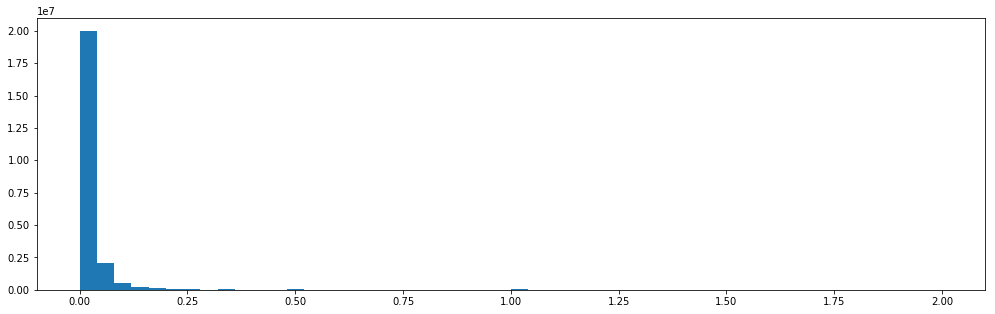

In [95]:
# before sparsifying
weight[np.isnan(weight)]=0
plt.rcParams['figure.figsize'] = (17, 5)
plt.hist(weight.reshape(-1), bins=50)
plt.show()

In [12]:
np.savetxt('../../Datasets/costs.csv',weight,delimiter=',')

In [96]:
treshold = 0.2
weight[weight<treshold] = 0

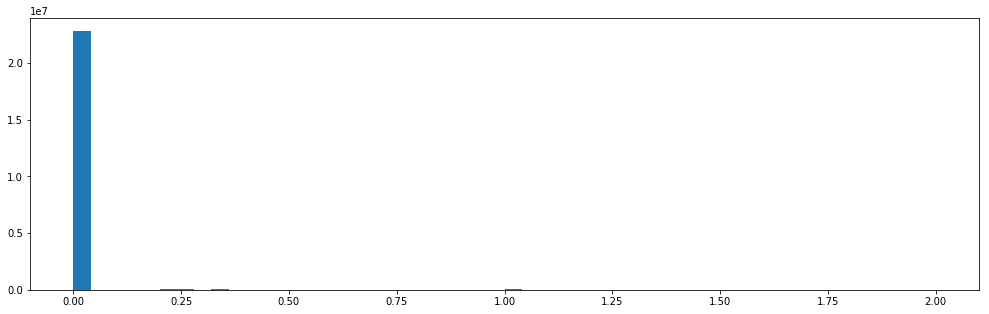

In [97]:
# after sparsifying
plt.rcParams['figure.figsize'] = (17, 5)
plt.hist(weight.reshape(-1), bins=50)
plt.show()

In [14]:
len(weight[np.where( weight > 0 )]) / costs.shape[0]

C:\Users\novak\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


61.13765855687253

In [62]:
np.mean(costs[500])

0.0055624870035350382

In [61]:
np.mean(cosine[500])

0.010619363934216888

In [77]:
np.mean(weight[500])

0.0060566749089624571

In [15]:
G = nx.from_numpy_matrix(weight)

In [16]:
knn = nx.k_nearest_neighbors(G)

In [17]:
n = 10 
reduce_G = nx.ego_graph(G, n, radius=1, center=True, undirected=False, distance=None)

C:\Users\novak\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7319: RuntimeWarning: invalid value encountered in greater
  mask = np.absolute(Z) > precision


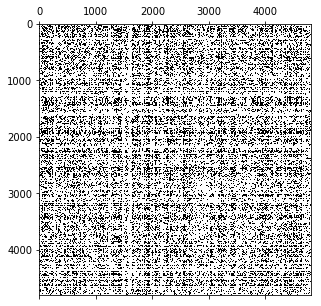

In [86]:
plt.spy(weight)
plt.show()

In [87]:
weight

array([[ 0.        ,         nan,         nan, ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.02505487,
         0.        ,  0.02338262],
       ..., 
       [ 0.        ,  0.        ,  0.02505487, ...,  0.        ,
         0.06506   ,  0.03456506],
       [ 0.        ,  0.        ,  0.        , ...,  0.06506   ,
         0.        ,  0.03035884],
       [ 0.        ,  0.        ,  0.02338262, ...,  0.03456506,
         0.03035884,  0.        ]])

In [88]:
# converting nan to 0
np.count_nonzero(weight)
# how much <>0
print(np.count_nonzero(weight)/len(costs)**2)
print(max(weight.reshape(-1)))
print(min(weight.reshape(-1)))
weight[np.isnan(weight)]=0

0.355581897652306
2.0
0.0


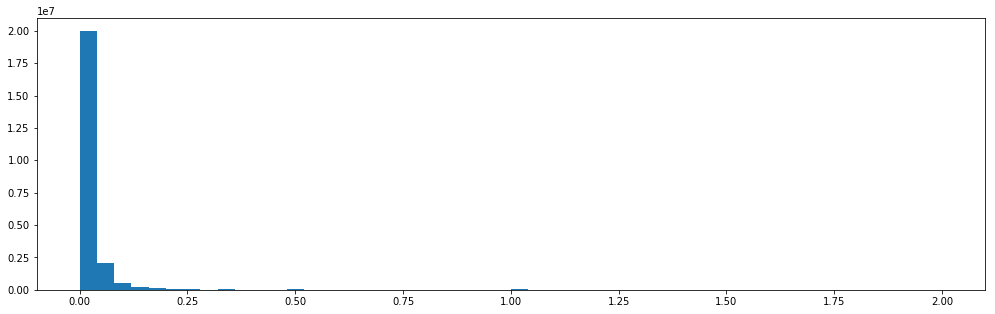

In [89]:
# weight distribution
plt.rcParams['figure.figsize'] = (17, 5)
plt.hist(weight.reshape(-1), bins=50)
plt.show()

In [90]:
# getting the weights after Gaussian kernel
kernel_width = weight.mean()
# Your code here.
# multiplication of two 1d np.arrays, using the np's matrices
w = np.exp(-(weight/kernel_width).T*(weight/kernel_width))
np.fill_diagonal(w,0)
print(w)

[[  0.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   1.00000000e+00
    1.00000000e+00   1.00000000e+00]
 [  1.00000000e+00   0.00000000e+00   1.00000000e+00 ...,   1.00000000e+00
    1.00000000e+00   1.00000000e+00]
 [  1.00000000e+00   1.00000000e+00   0.00000000e+00 ...,   1.36344079e-01
    1.00000000e+00   1.76317783e-01]
 ..., 
 [  1.00000000e+00   1.00000000e+00   1.36344079e-01 ...,   0.00000000e+00
    1.46209663e-06   2.25432974e-02]
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   1.46209663e-06
    0.00000000e+00   5.36377556e-02]
 [  1.00000000e+00   1.00000000e+00   1.76317783e-01 ...,   2.25432974e-02
    5.36377556e-02   0.00000000e+00]]


0.0
(array([], dtype=int64), array([], dtype=int64))


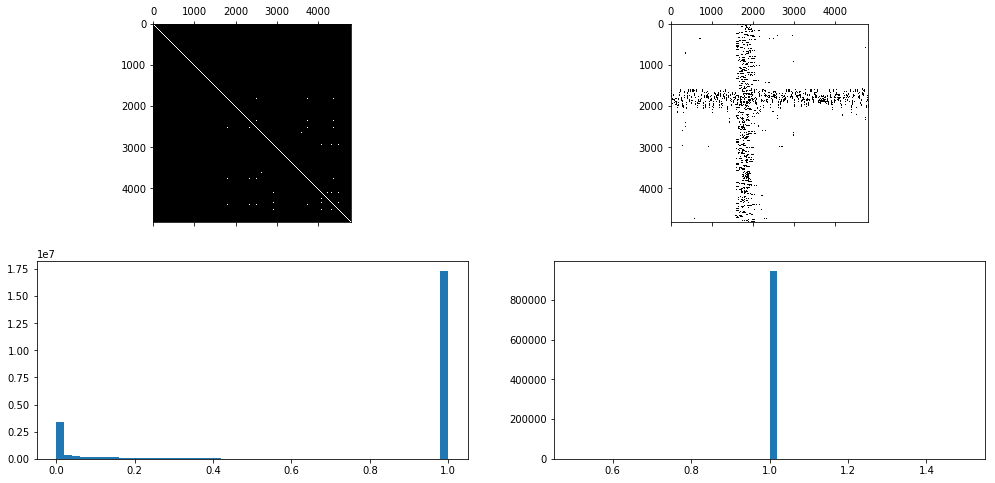

In [91]:
# sparsifying the distance matrix using kN and plotting before and after distribution

fix, axes = plt.subplots(2, 2, figsize=(17, 8))
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);
plot(w, axes[:, 0])

NEIGHBORS = 100
# Your code here.
weights_sparse = np.zeros_like(w)
print(sum(sum(weights_sparse)))

for i in range(w.shape[0]):
    keep_column= list(set(np.argsort(w[:,i])[-NEIGHBORS:]))   
    weights_sparse[keep_column,i] = w[keep_column,i]
    
bigger = weights_sparse.transpose() > weights_sparse
weights_sparse = weights_sparse - weights_sparse*bigger + weights_sparse.transpose()*bigger
#dict_discard[i] = list(set_both)

print(np.nonzero(weights_sparse-weights_sparse.transpose()))
plot(weights_sparse, axes[:, 1])
plt.show()